In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
#loading of data and EDA


from google.colab import drive
drive.mount('/content/drive')

!pip install dask
import dask.dataframe as dd

df = dd.read_csv("/content/drive/MyDrive/Drawing /complaints.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import dask.dataframe as dd

# Load all as string to avoid dtype mismatches
df = dd.read_csv(
    "/content/drive/MyDrive/Drawing /complaints.csv",
    dtype=str,
    assume_missing=True,
    low_memory=False,
    quoting=3,              # ignore quotes
    on_bad_lines="skip"
)

print(df.head())

print(df.dtypes)


                                                                                            Date received  \
2020-07-06 "Credit reporting                                                       credit repair services   
2019-12-26 Credit card or prepaid card                         General-purpose credit card or charge card   
2020-05-08 "Credit reporting                                                       credit repair services   
2025-09-23 Credit reporting or other personal consumer rep...                            Credit reporting   
2024-01-05 Credit reporting or other personal consumer rep...                            Credit reporting   

                                                                                            Product  \
2020-07-06 "Credit reporting                                    or other personal consumer reports"   
2019-12-26 Credit card or prepaid card                                   "Advertising and marketing   
2020-05-08 "Credit reporting        

In [18]:
df.to_parquet("/content/drive/MyDrive/Drawing/complaints_parquet", write_index=False)
print("✅ CSV successfully converted to Parquet")

✅ CSV successfully converted to Parquet


In [19]:
# Load much faster than CSV
df = dd.read_parquet("/content/drive/MyDrive/Drawing/complaints_parquet")
print(df.head())
print(df.dtypes)


                                Date received  \
0                      credit repair services   
1  General-purpose credit card or charge card   
2                      credit repair services   
3                            Credit reporting   
4                            Credit reporting   

                                Product                          Sub-product  \
0   or other personal consumer reports"                     Credit reporting   
1            "Advertising and marketing        including promotional offers"   
2   or other personal consumer reports"                     Credit reporting   
3  Incorrect information on your report  Information belongs to someone else   
4  Incorrect information on your report  Information belongs to someone else   

                                               Issue  \
0               Incorrect information on your report   
1  Confusing or misleading advertising about the ...   
2               Incorrect information on your report   


In [20]:
# Fix columns (example based on dataset)
df['Date received'] = dd.to_datetime(df['Date received'], errors='coerce')
df['ZIP code'] = dd.to_numeric(df['ZIP code'], errors='coerce')

# Handle disputed column
if 'Consumer disputed?' in df.columns:
    df['Consumer disputed?'] = df['Consumer disputed?'].map(
        {'Yes': 1, 'No': 0}, na_action='ignore'
    )

# Complaint narrative (main text feature)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].fillna('')

# Create target mapping
category_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df['target'] = df['Product'].map(category_map, na_action='ignore')


/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_collection.py:4208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('Consumer disputed?', 'float64'))

  warnings.warn(meta_warning(meta, method="map"))
/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_collection.py:4208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('Prod

In [21]:
# Keep only rows that belong to our 4 categories
df = df.dropna(subset=['target', 'Consumer complaint narrative'])

# Sample 5% of data
sample = df.sample(frac=0.05, random_state=42).compute()

print(sample.shape)
print(sample['target'].value_counts())


/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_expr.py:1546: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return get_meta_library(args[0]).to_datetime(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_expr.py:1546: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return get_meta_library(args[0]).to_datetime(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_expr.py:1546: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return get_meta_library(args[0]).to_datetime(*args, **kwargs)
/usr/local/lib/p

(13050, 19)
target
1.0    9244
3.0    3361
2.0     445
Name: count, dtype: int64


In [ ]:
STARTS FROM HERE

In [22]:
#STEP 1- MOUNT DRIVE AND LOAD DATASET
from google.colab import drive
import dask.dataframe as dd

# Mount Drive
drive.mount('/content/drive')

# Load dataset as Dask DataFrame
df = dd.read_parquet("/content/drive/MyDrive/Drawing/complaints_parquet")
print(df.head())
print(df.dtypes)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                Date received  \
0                      credit repair services   
1  General-purpose credit card or charge card   
2                      credit repair services   
3                            Credit reporting   
4                            Credit reporting   

                                Product                          Sub-product  \
0   or other personal consumer reports"                     Credit reporting   
1            "Advertising and marketing        including promotional offers"   
2   or other personal consumer reports"                     Credit reporting   
3  Incorrect information on your report  Information belongs to someone else   
4  Incorrect information on your report  Information belongs to someone else   

                                               Issue  \
0               Incorrect information o

In [23]:
#STEP 2-DATA CLEANING N FEATURE ENGINEERING
# Drop rows without target or text
df = df.dropna(subset=['Consumer complaint narrative', 'Product'])

# Map Product to 4 target categories
category_map = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df['target'] = df['Product'].map(category_map, na_action='ignore')

# Keep only necessary columns
df = df[['Consumer complaint narrative', 'target']]

# Sample 5% for training (to fit into memory)
sample = df.sample(frac=0.05, random_state=42).compute()
print(sample.shape)
print(sample['target'].value_counts())


/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_collection.py:4208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('Product', 'float64'))

  warnings.warn(meta_warning(meta, method="map"))


(224113, 2)
target
1.0    4188
3.0    1884
2.0     103
Name: count, dtype: int64


In [24]:
#STEP 3-TEXT PREPROCESSING
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(words)

sample['clean_text'] = sample['Consumer complaint narrative'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [26]:
#STEP-4:TRAIN N TEST SPLIT
# Drop rows where target or text is missing
sample = sample.dropna(subset=['clean_text', 'target'])

# Now define X and y
X = sample['clean_text']
y = sample['target']

# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape)
print("Test samples:", X_test.shape)
print("Class distribution in y_train:\n", y_train.value_counts())


Training samples: (4940,)
Test samples: (1235,)
Class distribution in y_train:
 target
1.0    3351
3.0    1507
2.0      82
Name: count, dtype: int64


In [27]:
#STEP-5:FEATURE ENGINEERING(TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    ngram_range=(1,2)   # Use unigrams + bigrams
)

# Fit TF-IDF on training data and transform both train & test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF feature shape (training):", X_train_tfidf.shape)
print("TF-IDF feature shape (testing):", X_test_tfidf.shape)


TF-IDF feature shape (training): (4940, 5000)
TF-IDF feature shape (testing): (1235, 5000)


In [28]:
#STEP-6:TRAINING MULTIMODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# Dictionary to store results
results = {}

# Train & evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_tfidf)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))



Training Logistic Regression...
Accuracy: 0.8996
Classification Report:
              precision    recall  f1-score   support

         1.0       0.89      0.98      0.93       837
         2.0       0.00      0.00      0.00        21
         3.0       0.92      0.78      0.84       377

    accuracy                           0.90      1235
   macro avg       0.60      0.58      0.59      1235
weighted avg       0.89      0.90      0.89      1235


Training Linear SVM...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9012
Classification Report:
              precision    recall  f1-score   support

         1.0       0.90      0.97      0.93       837
         2.0       1.00      0.05      0.09        21
         3.0       0.91      0.80      0.85       377

    accuracy                           0.90      1235
   macro avg       0.94      0.60      0.62      1235
weighted avg       0.90      0.90      0.89      1235


Training Naive Bayes...
Accuracy: 0.9053
Classification Report:
              precision    recall  f1-score   support

         1.0       0.90      0.98      0.94       837
         2.0       0.00      0.00      0.00        21
         3.0       0.93      0.79      0.86       377

    accuracy                           0.91      1235
   macro avg       0.61      0.59      0.60      1235
weighted avg       0.89      0.91      0.90      1235


Training Random Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8939
Classification Report:
              precision    recall  f1-score   support

         1.0       0.89      0.97      0.93       837
         2.0       0.00      0.00      0.00        21
         3.0       0.91      0.77      0.83       377

    accuracy                           0.89      1235
   macro avg       0.60      0.58      0.59      1235
weighted avg       0.88      0.89      0.88      1235



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
#STEP=7:EXAMPLE PREDICTION
# Example complaints
example_text = [
    "The bank keeps calling me every day to collect a debt I don’t owe.",
    "I was wrongly reported to a credit bureau for an unpaid account.",
    "My mortgage application was delayed unfairly by the lender."
]

# Preprocess the text same as training
example_clean = [clean_text(t) for t in example_text]

# Transform to TF-IDF using the same vectorizer
example_tfidf = tfidf.transform(example_clean)

# Use the best model (Linear SVM recommended)
best_model = LinearSVC()
best_model.fit(X_train_tfidf, y_train)  # Train on full training data

# Predict categories
predictions = best_model.predict(example_tfidf)

# Map numeric labels back to category names (optional)
category_map_reverse = {
    0: 'Credit reporting, repair, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

for text, pred in zip(example_text, predictions):
    print(f"Complaint: {text}\nPredicted Category: {category_map_reverse[pred]}\n")


Complaint: The bank keeps calling me every day to collect a debt I don’t owe.
Predicted Category: Debt collection

Complaint: I was wrongly reported to a credit bureau for an unpaid account.
Predicted Category: Debt collection

Complaint: My mortgage application was delayed unfairly by the lender.
Predicted Category: Mortgage



In [30]:
#STEP-7:PREDICTION(INTERACTIVE)
# Train the best model on full training data
best_model = LinearSVC()
best_model.fit(X_train_tfidf, y_train)  # Train on full training set

# Reverse mapping from numeric label to category
category_map_reverse = {
    0: 'Credit reporting, repair, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

# Function to predict user input
def predict_complaint(text):
    # Preprocess
    clean = clean_text(text)
    # TF-IDF transform
    vec = tfidf.transform([clean])
    # Predict
    pred = best_model.predict(vec)[0]
    # Map to category
    return category_map_reverse[pred]

# Interactive loop
while True:
    user_input = input("\nEnter a consumer complaint (or type 'exit' to quit):\n")
    if user_input.lower() == 'exit':
        print("Exiting...")
        break
    category = predict_complaint(user_input)
    print(f"Predicted Category: {category}")



Enter a consumer complaint (or type 'exit' to quit):
The bank is calling me to pay a debt I never owed.
Predicted Category: Debt collection

Enter a consumer complaint (or type 'exit' to quit):
EXIT
Exiting...


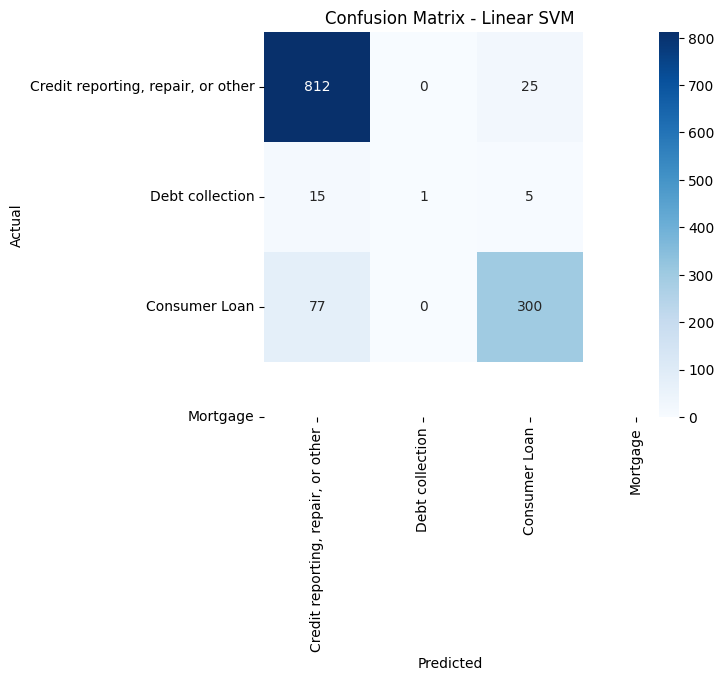

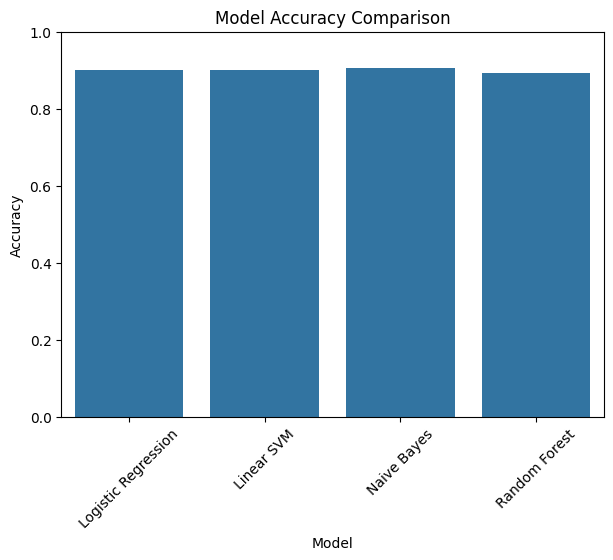

In [31]:
#STEP=8:VISUALISATIONS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on test set using the best model
best_preds = best_model.predict(X_test_tfidf)

# Confusion Matrix
cm = confusion_matrix(y_test, best_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_map_reverse.values(), yticklabels=category_map_reverse.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM")
plt.show()

# Model comparison bar chart
import pandas as pd

# Assuming 'results' dictionary from Step 6
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
plt.figure(figsize=(7,5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


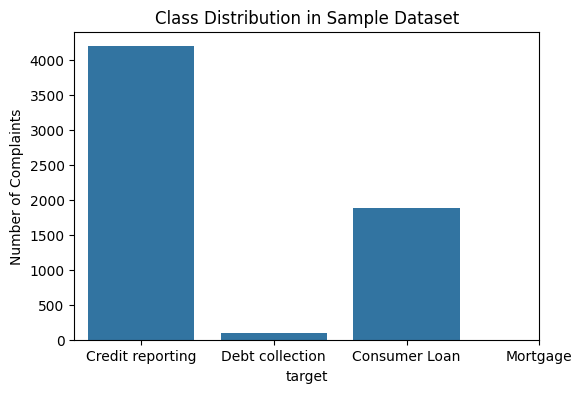

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=sample['target'])
plt.xticks([0,1,2,3], ['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage'])
plt.title("Class Distribution in Sample Dataset")
plt.ylabel("Number of Complaints")
plt.show()


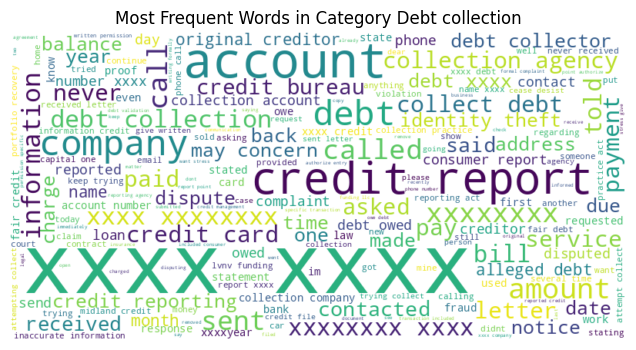

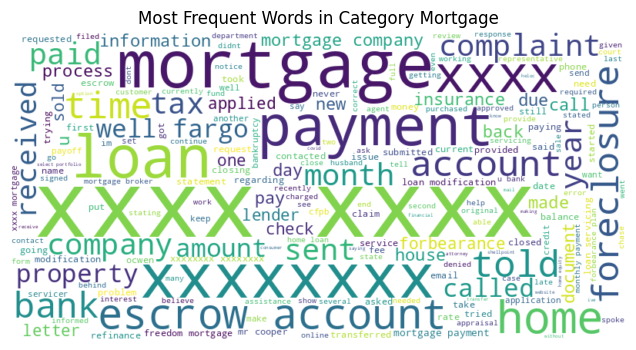

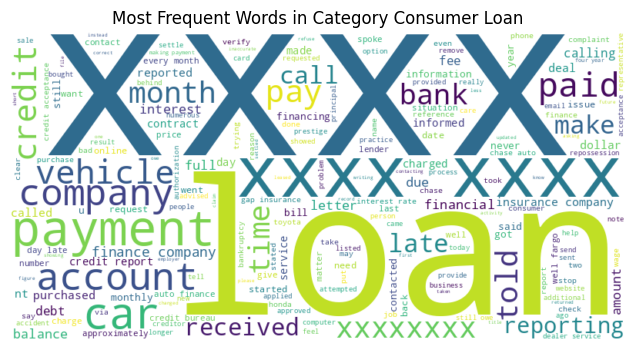

In [33]:
from wordcloud import WordCloud

categories = sample['target'].unique()
for cat in categories:
    text = " ".join(sample[sample['target']==cat]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most Frequent Words in Category {category_map_reverse[cat]}")
    plt.show()



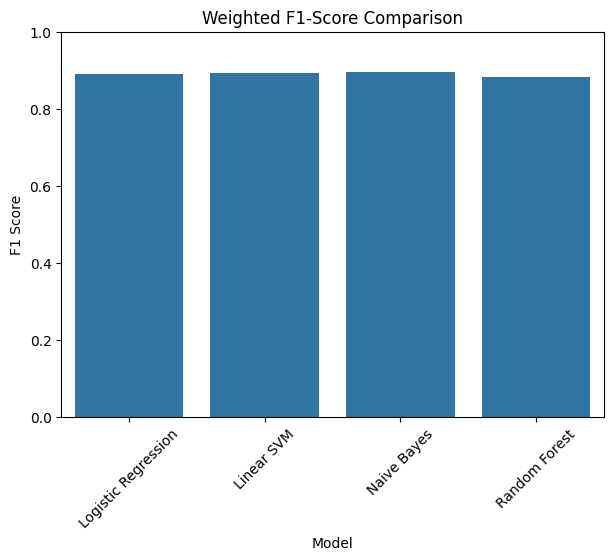

In [34]:
from sklearn.metrics import f1_score

f1_scores = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    f1_scores[name] = f1_score(y_test, preds, average='weighted')

# Bar plot for F1-score
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Model','F1 Score'])
plt.figure(figsize=(7,5))
sns.barplot(x='Model', y='F1 Score', data=f1_df)
plt.ylim(0,1)
plt.title("Weighted F1-Score Comparison")
plt.xticks(rotation=45)
plt.show()
